# Quick start

Welcome to the quick start guide for AlphaGenome! The goal of this tutorial
notebook is to quickly get you started with using the model and making
predictions.

```{tip}
Open this tutorial in Google Colab for interactive viewing.
```

In [ ]:
# @title Install AlphaGenome

# @markdown Run this cell to install AlphaGenome.
from IPython.display import clear_output
! pip install alphagenome
clear_output()

## Imports

In [ ]:
from alphagenome import colab_utils
from alphagenome.data import gene_annotation
from alphagenome.data import genome
from alphagenome.data import transcript as transcript_utils
from alphagenome.interpretation import ism
from alphagenome.models import dna_client
from alphagenome.models import variant_scorers
from alphagenome.visualization import plot_components
import matplotlib.pyplot as plt
import pandas as pd

## Predict outputs for a DNA sequence

AlphaGenome is a model that makes predictions from DNA sequences. Let's load it
up:

```{tip}
If using Google Colab, store your key in "Secrets" for persistent access across sessions (see [installation](https://www.alphagenomedocs.com/installation.html#google-colab)). Otherwise, `dna_client.create` can take the API key directly.
```

In [ ]:
import pandas as pd
from alphagenome.data import genome
from alphagenome.models import dna_client, variant_scorers


df = pd.read_csv("test.tsv", sep="\t")

df.columns = [c.lower().replace("#", "") for c in df.columns]


required = {"chr", "pos", "ref", "alt"}



dna_model = dna_client.create(colab_utils.get_api_key())
variant_scorer = variant_scorers.RECOMMENDED_VARIANT_SCORERS["RNA_SEQ"]

results = []


for idx, row in df.iterrows():

    chrom = f"chr{row['chr']}"
    pos = int(row['pos'])
    ref = row['ref']
    alt = row['alt']

    variant = genome.Variant(
        chromosome=chrom,
        position=pos,
        reference_bases=ref,
        alternate_bases=alt
    )

    interval = genome.Interval(chrom, pos, pos+1).resize(
        dna_client.SEQUENCE_LENGTH_1MB
    )

    scores = dna_model.score_variant(
        interval=interval,
        variant=variant,
        variant_scorers=[variant_scorer]

    )

    tidy = variant_scorers.tidy_scores([scores[0]], match_gene_strand=True)

    score_column = tidy['raw_score']

    results.append({
        "chr": row["chr"],
        "pos": pos,
        "ref": ref,
        "alt": alt,
        "score_mean": float(score_column.mean()),
        "score_max": float(score_column.max()),
    })


pd.DataFrame(results).to_csv("variant_scores.csv", index=False)


The model can make predictions for the following
[output types](https://www.alphagenomedocs.com/exploring_model_metadata.html):

In [ ]:
[output.name for output in dna_client.OutputType]

['ATAC',
 'CAGE',
 'DNASE',
 'RNA_SEQ',
 'CHIP_HISTONE',
 'CHIP_TF',
 'SPLICE_SITES',
 'SPLICE_SITE_USAGE',
 'SPLICE_JUNCTIONS',
 'CONTACT_MAPS',
 'PROCAP']

AlphaGenome predicts multiple 'tracks' per output type, covering a wide variety
of tissues and cell-types. However, predictions can be made efficiently for
subsets of interest.

Here is how to make DNase-seq predictions (as specified by `OutputType`) in a
subset of tracks corresponding to lung tissue (as specified by `ontology_terms`)
for a DNA sequence of length 1Mb:

*Note: We use ontology terms from standardized biological sources like UBERON
(for anatomy) and the Cell Ontology (CL) to provide consistent and widely
recognized classifications for tissue and cell types.*

In [ ]:
output = dna_model.predict_sequence(
    sequence='GATTACA'.center(
        dna_client.SEQUENCE_LENGTH_1MB, 'N'
    ),  # Pad to valid sequence length.
    requested_outputs=[dna_client.OutputType.DNASE],
    ontology_terms=['UBERON:0002048'],  # Lung.
)

The `output` object contains predictions for all the different requested output
types (in this case, only output type `DNASE`). Predictions for genomic tracks
are stored inside a `TrackData` object:

In [ ]:
dnase = output.dnase
type(dnase)

alphagenome.data.track_data.TrackData

`TrackData` objects have the following components:

<a href="https://services.google.com/fh/files/misc/trackdata.png"><img src="https://services.google.com/fh/files/misc/trackdata.png" alt="trackdata" border="0" height=500></a>

The predictions of shape `(sequence_length, num_tracks)` are stored in
`.values`:

In [ ]:
print(dnase.values.shape)

dnase.values

(1048576, 1)


array([[0.00187683],
       [0.00177765],
       [0.00177765],
       ...,
       [0.0019989 ],
       [0.00292969],
       [0.0039978 ]], dtype=float32)

And the corresponding metadata describing each of the tracks is stored in
`.metadata`:

In [ ]:
dnase.metadata

,name,strand,Assay title,ontology_curie,biosample_name,biosample_type,biosample_life_stage,data_source,endedness,genetically_modified,nonzero_mean
0,UBERON:0002048 DNase-seq,.,DNase-seq,UBERON:0002048,lung,tissue,embryonic,encode,paired,False,0.427505


In this case, there is only one output track, so the track metadata returns only
1 row.

The track metadata is especially useful when requesting predictions for multiple
tissues or cell-types, and when dealing with stranded assays (which are assays
with separate readouts for the two DNA strands, such as CAGE and RNA-seq):

In [ ]:
output = dna_model.predict_sequence(
    sequence='GATTACA'.center(
        dna_client.SEQUENCE_LENGTH_1MB, 'N'
    ),  # Pad to valid sequence length.
    requested_outputs=[
        dna_client.OutputType.CAGE,
        dna_client.OutputType.DNASE,
    ],
    ontology_terms=[
        'UBERON:0002048',  # Lung.
        'UBERON:0000955',  # Brain.
    ],
)

print(f'DNASE predictions shape: {output.dnase.values.shape}')
print(f'CAGE predictions shape: {output.cage.values.shape}')

DNASE predictions shape: (1048576, 2)
CAGE predictions shape: (1048576, 4)


Notice that in this example, we requested predictions for 2 assays and 2
ontology terms simultaneously.

The CAGE track metadata describes the strand and tissue of each of the 4
predicted tracks (2 per DNA strand):

In [ ]:
output.cage.metadata

,name,strand,Assay title,ontology_curie,biosample_name,biosample_type,data_source,nonzero_mean
0,hCAGE UBERON:0000955,+,hCAGE,UBERON:0000955,brain,tissue,fantom,28.432245
1,hCAGE UBERON:0002048,+,hCAGE,UBERON:0002048,lung,tissue,fantom,30.655853
2,hCAGE UBERON:0000955,-,hCAGE,UBERON:0000955,brain,tissue,fantom,28.432245
3,hCAGE UBERON:0002048,-,hCAGE,UBERON:0002048,lung,tissue,fantom,30.655853


See the
[output metadata documentation](https://www.alphagenomedocs.com/exploring_model_metadata.html)
for more information on the output types and output shapes. For the mapping
between tissue names (e.g. 'brain' -> 'UBERON:0000955') and ontology terms, see
this [tutorial](tissue_ontology_mapping.ipynb).

## Predict outputs for a genome interval (reference genome)

For convenience, you can also directly make predictions for a human reference
genome sequence specified by a **genomic interval**. For example, let's predict
RNA-seq for tissue 'Right liver lobe' in a 1MB region of Chromosome 19 around
the gene *CYP2B6*, which encodes an enzyme involved in drug metabolism, and is
primarily expressed in the liver.

We first load up a GTF file containing gene and transcript locations as
annotated by GENCODE (more information on GTF format
[here](https://www.gencodegenes.org/pages/data_format.html)):

In [ ]:
# The GTF file contains information on the location of all trancripts.
# Note that we use genome assembly hg38 for human.
gtf = pd.read_feather(
    'https://storage.googleapis.com/alphagenome/reference/gencode/'
    'hg38/gencode.v46.annotation.gtf.gz.feather'
)

# Set up transcript extractors using the information in the GTF file.
# Mane select transcripts consists of of one curated transcript per locus.
gtf_transcripts = gene_annotation.filter_protein_coding(gtf)
gtf_transcripts = gene_annotation.filter_to_mane_select_transcript(gtf_transcripts)
transcript_extractor = transcript_utils.TranscriptExtractor(gtf_transcripts)

And then fetch the gene's location as a `genome.Interval` object by passing
either its `gene_symbol` (HGNC naming convention) or ENSEMBL `gene_id`:

In [ ]:
interval = gene_annotation.get_gene_interval(gtf, gene_symbol='CYP2B6')
interval

Interval(chromosome='chr19', start=40991281, end=41018398, strand='+', name='CYP2B6')

We can resize it to a length compatible with the model:

In [ ]:
interval = interval.resize(dna_client.SEQUENCE_LENGTH_1MB)

The `.resize()` method adjusts the interval to the specified width by expanding
(or contracting) around its original center. Note that
`dna_model.predict_interval()` interprets this resizing as an expansion of the
actual genomic sequence rather than padding tokens.

In [ ]:
interval.width

1048576

See the
[essential commands documentation](https://www.alphagenomedocs.com/colabs/essential_commands.html)
for more handy commands like `resize`.

Note that AlphaGenome supports the following input sequence lengths:

In [ ]:
dna_client.SUPPORTED_SEQUENCE_LENGTHS.keys()

dict_keys(['SEQUENCE_LENGTH_16KB', 'SEQUENCE_LENGTH_100KB', 'SEQUENCE_LENGTH_500KB', 'SEQUENCE_LENGTH_1MB'])

We can now make predictions using our interval:

In [ ]:
output = dna_model.predict_interval(
    interval=interval,
    requested_outputs=[dna_client.OutputType.RNA_SEQ],
    ontology_terms=['UBERON:0001114'],
)  # Right liver lobe.

output.rna_seq.values.shape

(1048576, 3)

In general, you can have multiple tracks for a given ontology term. In this
case, we have 3 RNA-seq tracks for the tissue "Right liver lobe".

Let's visualise these predictions. It's helpful visualise gene transcripts
alongside the predicted tracks, so we extract them here:

In [ ]:
transcripts = transcript_extractor.extract(interval)
print(f'Extracted {len(transcripts)} transcripts in this interval.')

Extracted 28 transcripts in this interval.


We also provide a
[visualization basics guide](https://www.alphagenomedocs.com/visualization_library_basics.html)
that integrates nicely with `TrackData` and other objects returned by the model
API.

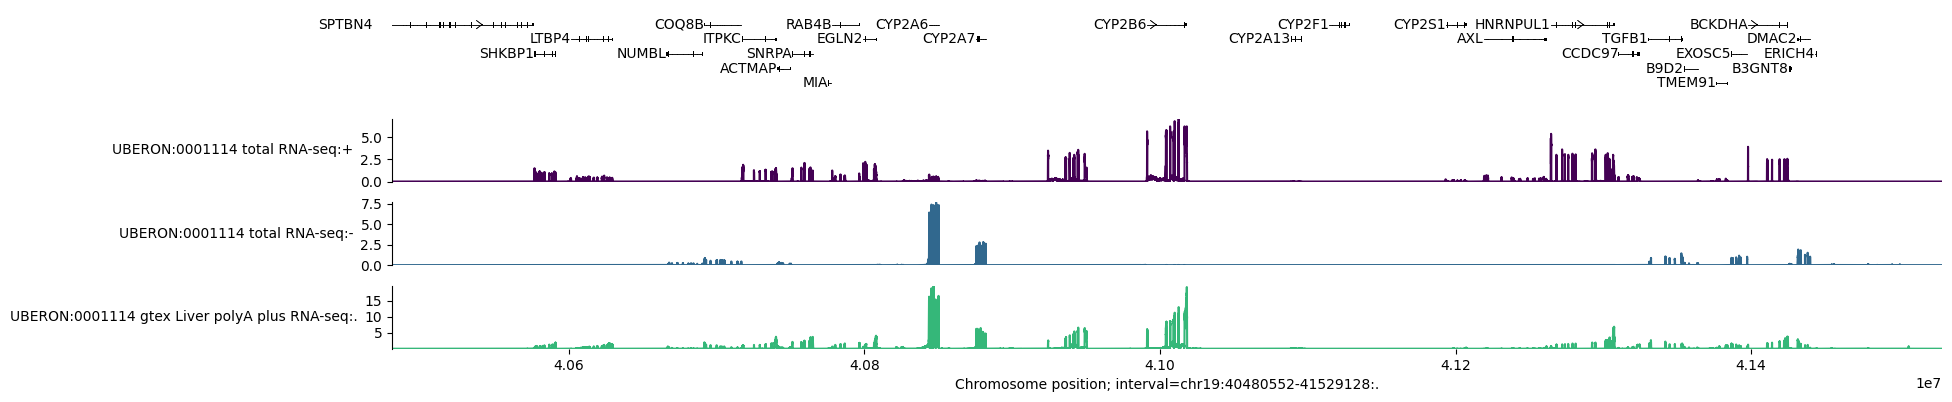

In [ ]:
plot_components.plot(
    components=[
        plot_components.TranscriptAnnotation(transcripts),
        plot_components.Tracks(output.rna_seq),
    ],
    interval=output.rna_seq.interval,
)

plt.show()

This plot visualises the 3 predicted RNA-seq tracks and also marks the location
of the MANE select transcript per gene in the 1MB region.

We can zoom in to the middle of the plot by resizing the interval:

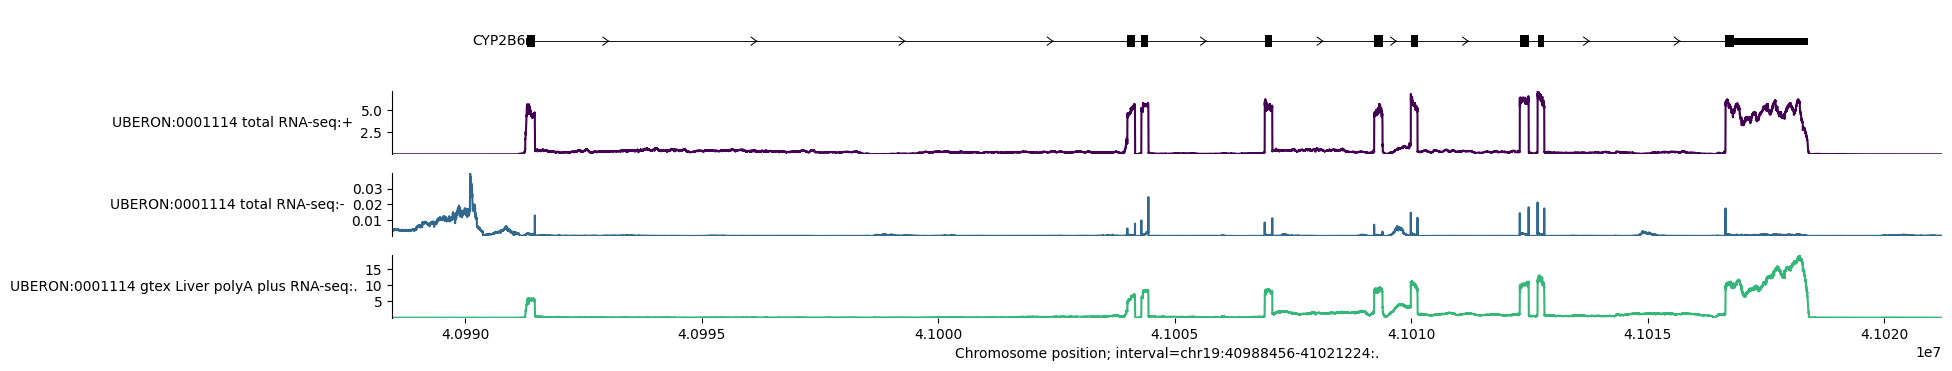

In [ ]:
plot_components.plot(
    components=[
        plot_components.TranscriptAnnotation(
            transcripts, fig_height=0.1
        ),
        plot_components.Tracks(output.rna_seq),
    ],
    interval=output.rna_seq.interval.resize(2**15),
)

plt.show()

You can see here that predicted RNA-seq values are nicely aligned with the
location of exons, and that the predictions are stranded – the predicted values
are much higher for the positive strand, where the gene is located. We see that
the *CYP2B6* gene is on the positive strand since the arrows in the transcript
go from left to right.

For more detail on the visualization library, please refer to the
[visualization basics guide](https://www.alphagenomedocs.com/visualization_library_basics.html)
and
[library documentation](https://www.alphagenomedocs.com/api/visualization.html).

## Predict variant effects

We can predict the effect of a variant on a specific output type and tissue by
making predictions for the reference (REF) and alternative (ALT) allele
sequences.

We specify the variant by defining a `genome.Variant` object. The specific
variant below is a known variant affecting gene expression in colon tissue:

In [ ]:
variant = genome.Variant(
    chromosome='chr22',
    position=36201698,
    reference_bases='A',  # Can differ from the true reference genome base.
    alternate_bases='C',
)

Next, we define the interval over which to make the REF and ALT predictions. A
quick way to get a `genome.Interval` from a `genome.Variant` is by calling
`.reference_interval`, which we can resize to a model-compatible sequence
length:

In [ ]:
interval = variant.reference_interval.resize(dna_client.SEQUENCE_LENGTH_1MB)

We then use `predict_variant` to get the REF and ALT RNA-seq predictions in the
interval for "Colon - Transverse" tissue (`UBERON:0001157`):

In [ ]:
variant_output = dna_model.predict_variant(
    interval=interval,
    variant=variant,
    requested_outputs=[dna_client.OutputType.RNA_SEQ],
    ontology_terms=['UBERON:0001157'],
)  # Colon - Transverse.

We can plot the predicted REF and ALT values as a single plot and zoom in on the
affected gene to better visualise the variant's effect on gene expression:

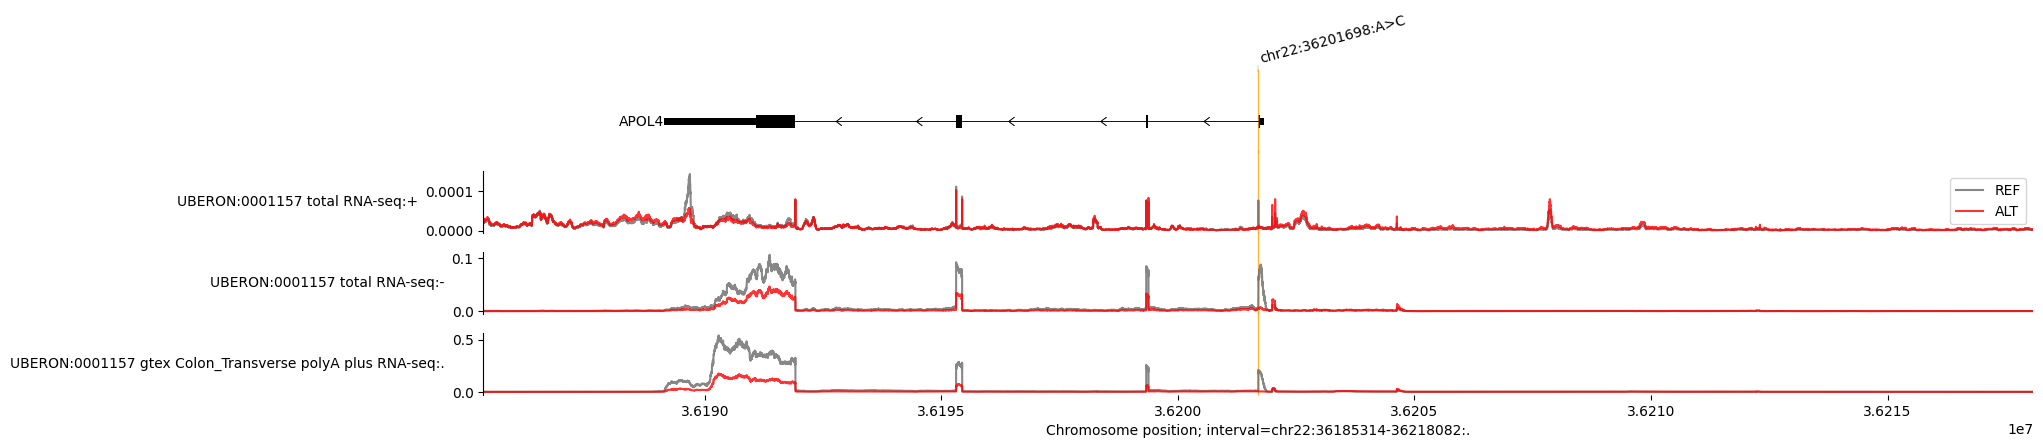

In [ ]:
transcripts = transcript_extractor.extract(interval)

plot_components.plot(
    [
        plot_components.TranscriptAnnotation(transcripts),
        plot_components.OverlaidTracks(
            tdata={
                'REF': variant_output.reference.rna_seq,
                'ALT': variant_output.alternate.rna_seq,
            },
            colors={'REF': 'dimgrey', 'ALT': 'red'},
        ),
    ],
    interval=variant_output.reference.rna_seq.interval.resize(2**15),
    # Annotate the location of the variant as a vertical line.
    annotations=[plot_components.VariantAnnotation([variant], alpha=0.8)],
)
plt.show()

We see that the ALT allele (base 'C' at position 36201698) is associated with
both lower expression and an exon skipping event in the *APOL4* gene on the
negative strand. Note that we can ignore the uppermost line plot which shows a
very minimal predicted amount of expression on the positive DNA strand (check
the y axis scales). It is possible to adjust the y axes limits, see
[visualization basics](https://www.alphagenomedocs.com/visualization_library_basics.html#visualization-library-basics)
and
[library documentation](https://www.alphagenomedocs.com/api/visualization.html).

## Scoring the effect of a genetic variant

Scoring the effect of a genetic variant involves making predictions for the REF
and ALT sequences and aggregating the track signal. This is implemented in
`score_variant`, which uses specific `variant_scorer` configs for aggregation.

We provide a set of recommended variant scoring configurations as a dictionary
(`variant_scorers.RECOMMENDED_VARIANT_SCORERS`), covering all output types,
which we have assessed for their performance at domain-specific tasks. See the
[variant scoring documentation](https://www.alphagenomedocs.com/variant_scoring.html)
for more information. Here is a quick demo:

In [ ]:
variant_scorer = variant_scorers.RECOMMENDED_VARIANT_SCORERS['RNA_SEQ']

variant_scores = dna_model.score_variant(
    interval=interval, variant=variant, variant_scorers=[variant_scorer]
)

The returned `variant_scores` is a list of length 1 because we only specified 1
scorer:

In [ ]:
len(variant_scores)

1

The actual scores per variant are in `AnnData` format, which is a way of
annotating data (the numerical scores) with additional information about the
rows and columns.

In [ ]:
variant_scores = variant_scores[0]
variant_scores

AnnData object with n_obs × n_vars = 37 × 667
    obs: 'gene_id', 'strand', 'gene_name', 'gene_type'
    var: 'name', 'strand', 'Assay title', 'ontology_curie', 'biosample_name', 'biosample_type', 'biosample_life_stage', 'gtex_tissue', 'data_source', 'endedness', 'genetically_modified', 'nonzero_mean'
    uns: 'interval', 'variant', 'variant_scorer'
    layers: 'quantiles'

`AnnData` objects have the following components:

<a href="https://services.google.com/fh/files/misc/anndata.png"><img src="https://services.google.com/fh/files/misc/anndata.png" alt="anndata" border="0" height=500></a>

We have a variant effect score for each of the 37 genes in the interval and each
of the 667 `RNA_SEQ` tracks:

In [ ]:
variant_scores.X.shape

(37, 667)

We can access information on the 37 genes using `.obs`. Here are just first 5
genes:

In [ ]:
variant_scores.obs.head()

,gene_id,strand,gene_name,gene_type
0,ENSG00000100320.24,-,RBFOX2,protein_coding
1,ENSG00000100336.18,-,APOL4,protein_coding
2,ENSG00000100342.22,+,APOL1,protein_coding
3,ENSG00000100345.23,-,MYH9,protein_coding
4,ENSG00000100348.10,-,TXN2,protein_coding


Note that if you are using a variant scorer that is not gene-specific (i.e., a
`variant_scorers.CenterMaskScorer`), then `variant_scores.X` would have shape
`(1, 667)` and there will be no gene metadata available since there is no
concept of genes in this scenario.

The description of each track is accessed using `.var` (this is the same
dataframe as the output metadata, but is included alongside the variant scores
for convenience):

In [ ]:
variant_scores.var

,name,strand,Assay title,ontology_curie,biosample_name,biosample_type,biosample_life_stage,gtex_tissue,data_source,endedness,genetically_modified,nonzero_mean
0,CL:0000047 polyA plus RNA-seq,+,polyA plus RNA-seq,CL:0000047,neuronal stem cell,in_vitro_differentiated_cells,embryonic,,encode,paired,False,0.143617
1,CL:0000062 total RNA-seq,+,total RNA-seq,CL:0000062,osteoblast,primary_cell,adult,,encode,paired,False,0.094144
2,CL:0000084 polyA plus RNA-seq,+,polyA plus RNA-seq,CL:0000084,T-cell,primary_cell,adult,,encode,paired,False,0.124296
3,CL:0000084 total RNA-seq,+,total RNA-seq,CL:0000084,T-cell,primary_cell,adult,,encode,single,False,0.100934
4,CL:0000115 total RNA-seq,+,total RNA-seq,CL:0000115,endothelial cell,in_vitro_differentiated_cells,adult,,encode,single,False,0.135553
...,...,...,...,...,...,...,...,...,...,...,...,...
662,UBERON:0018115 polyA plus RNA-seq,.,polyA plus RNA-seq,UBERON:0018115,left renal pelvis,tissue,embryonic,,encode,single,False,0.268222
663,UBERON:0018116 polyA plus RNA-seq,.,polyA plus RNA-seq,UBERON:0018116,right renal pelvis,tissue,embryonic,,encode,single,False,0.258522
664,UBERON:0018117 polyA plus RNA-seq,.,polyA plus RNA-seq,UBERON:0018117,left renal cortex interstitium,tissue,embryonic,,encode,single,False,0.215190
665,UBERON:0018118 polyA plus RNA-seq,.,polyA plus RNA-seq,UBERON:0018118,right renal cortex interstitium,tissue,embryonic,,encode,single,False,0.365676


Some handy additional metadata can be found in `.uns`:

In [ ]:
print(f'Interval: {variant_scores.uns["interval"]}')
print(f'Variant: {variant_scores.uns["variant"]}')
print(f'Variant scorer: {variant_scores.uns["variant_scorer"]}')

Interval: chr22:35677410-36725986:.
Variant: chr22:36201698:A>C
Variant scorer: GeneMaskLFCScorer(requested_output=RNA_SEQ)


We recommend interacting with variant scores by flattening `AnnData` objects
using `tidy_scores`, which produces a dataframe with each row being a single
score for each combination of (variant, gene, scorer, ontology). It optionally
excludes stranded tracks which do not match the gene’s strand for gene-specific
scorer.

The `raw_score` column contains the same values as stored in `variant_scores.X`.
The `quantile_score` column is the rank of the `raw_score` in the distribution
of scores for a background set of common variants, represented as a quantile
probability. This allows for direct comparison across variant scoring strategies
that yield scores on different scales. See
[FAQs](https://www.alphagenomedocs.com/faqs.html#what-is-the-difference-between-a-quantile-score-and-raw-score)
for further details.

In [ ]:

variant_scorers.tidy_scores([variant_scores], match_gene_strand=True)

,variant_id,scored_interval,gene_id,gene_name,gene_type,gene_strand,junction_Start,junction_End,output_type,variant_scorer,...,ontology_curie,biosample_name,biosample_type,biosample_life_stage,gtex_tissue,data_source,endedness,genetically_modified,raw_score,quantile_score
0,chr22:36201698:A>C,chr22:35677410-36725986:.,ENSG00000100320,RBFOX2,protein_coding,-,None,None,RNA_SEQ,GeneMaskLFCScorer(requested_output=RNA_SEQ),...,CL:0000047,neuronal stem cell,in_vitro_differentiated_cells,embryonic,,encode,paired,False,0.001068,6.486191e-01
1,chr22:36201698:A>C,chr22:35677410-36725986:.,ENSG00000100320,RBFOX2,protein_coding,-,None,None,RNA_SEQ,GeneMaskLFCScorer(requested_output=RNA_SEQ),...,CL:0000062,osteoblast,primary_cell,adult,,encode,paired,False,-0.000143,-3.431121e-01
2,chr22:36201698:A>C,chr22:35677410-36725986:.,ENSG00000100320,RBFOX2,protein_coding,-,None,None,RNA_SEQ,GeneMaskLFCScorer(requested_output=RNA_SEQ),...,CL:0000084,T-cell,primary_cell,adult,,encode,paired,False,-0.000452,-4.312567e-01
3,chr22:36201698:A>C,chr22:35677410-36725986:.,ENSG00000100320,RBFOX2,protein_coding,-,None,None,RNA_SEQ,GeneMaskLFCScorer(requested_output=RNA_SEQ),...,CL:0000084,T-cell,primary_cell,adult,,encode,single,False,-0.001039,-6.418862e-01
4,chr22:36201698:A>C,chr22:35677410-36725986:.,ENSG00000100320,RBFOX2,protein_coding,-,None,None,RNA_SEQ,GeneMaskLFCScorer(requested_output=RNA_SEQ),...,CL:0000115,endothelial cell,in_vitro_differentiated_cells,adult,,encode,single,False,0.000349,3.831612e-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14647,chr22:36201698:A>C,chr22:35677410-36725986:.,ENSG00000293594,ENSG00000293594,processed_pseudogene,-,None,None,RNA_SEQ,GeneMaskLFCScorer(requested_output=RNA_SEQ),...,UBERON:0018115,left renal pelvis,tissue,embryonic,,encode,single,False,0.002708,8.917613e-01
14648,chr22:36201698:A>C,chr22:35677410-36725986:.,ENSG00000293594,ENSG00000293594,processed_pseudogene,-,None,None,RNA_SEQ,GeneMaskLFCScorer(requested_output=RNA_SEQ),...,UBERON:0018116,right renal pelvis,tissue,embryonic,,encode,single,False,0.007722,9.939092e-01
14649,chr22:36201698:A>C,chr22:35677410-36725986:.,ENSG00000293594,ENSG00000293594,processed_pseudogene,-,None,None,RNA_SEQ,GeneMaskLFCScorer(requested_output=RNA_SEQ),...,UBERON:0018117,left renal cortex interstitium,tissue,embryonic,,encode,single,False,0.005573,9.824973e-01
14650,chr22:36201698:A>C,chr22:35677410-36725986:.,ENSG00000293594,ENSG00000293594,processed_pseudogene,-,None,None,RNA_SEQ,GeneMaskLFCScorer(requested_output=RNA_SEQ),...,UBERON:0018118,right renal cortex interstitium,tissue,embryonic,,encode,single,False,0.004530,9.645371e-01


## Highlighting important regions with *in silico* mutagenesis

To highlight which regions in a DNA sequence are functionally important for a
final variant prediction, we can perform an **in silico mutagenesis** (ISM)
analysis by scoring all possible single nucleotide variants in a specific
interval.

Here is a visual overview of this process:

<a href="https://services.google.com/fh/files/misc/ism_green_v2.png"><img src="https://services.google.com/fh/files/misc/ism_green_v2.png" alt="ISM" border="0" height=500></a>

We define an `ism_interval`, which is a relatively small region of DNA that we
want to systematically mutate. We also define the `sequence_interval`, which is
the contextual interval the model will use when making predictions for each
variant.

In [ ]:
# 16KB DNA sequence to use as context when making predictions.
sequence_interval = genome.Interval('chr20', 3_753_000, 3_753_400)
sequence_interval = sequence_interval.resize(dna_client.SEQUENCE_LENGTH_16KB)

# Mutate all bases in the central 256-base region of the sequence_interval.
ism_interval = sequence_interval.resize(256)

Next, we define the scorer we want to use to score each of the ISM variants.
Here, we use a center mask scorer on predicted `DNASE` values, which will score
each variant's effect on DNA accessibility in the 500bp vicinity. See the
[variant scoring documentation](https://www.alphagenomedocs.com/variant_scoring.html)
for more information on variant scoring.

In [ ]:
dnase_variant_scorer = variant_scorers.CenterMaskScorer(
    requested_output=dna_client.OutputType.DNASE,
    width=501,
    aggregation_type=variant_scorers.AggregationType.DIFF_MEAN,
)

Finally, we can use `score_variants` (notice the plural s) to score all
variants.

Note that this operation is quite expensive. For speed reasons, we recommend
using shorter input sequences for the contextual `sequence_interval` and
narrower `ism_interval` regions to mutate if possible.

In [ ]:
variant_scores = dna_model.score_ism_variants(
    interval=sequence_interval,
    ism_interval=ism_interval,
    variant_scorers=[dnase_variant_scorer],
)

  0%|          | 0/26 [00:00<?, ?it/s]

The length of the returned `variant_scores` is 768, since we scored 768 variants
(256 positions * 3 alternative bases per position):

In [ ]:
len(variant_scores)

768

Each variant has scores of shape `(1, 305)`, reflecting the fact that we are not
using a gene-centric scorer and that there are 305 `DNASE` tracks:

In [ ]:
# Index into first variant and first scorer.
variant_scores[0][0].X.shape

(1, 305)

To understand which positions are most influential in the predictions, we can
visualize these scores using a sequence logo. This requires summarizing the
scores into a single scalar value per variant.

As an example, let's extract the DNASE score for just the K562 cell line, a
widely used experimental model. Alternatively, you could average across multiple
tissues to obtain a single scalar value.

In [ ]:
def extract_k562(adata):
  values = adata.X[:, adata.var['ontology_curie'] == 'EFO:0002067']
  assert values.size == 1
  return values.flatten()[0]


ism_result = ism.ism_matrix(
    [extract_k562(x[0]) for x in variant_scores],
    variants=[v[0].uns['variant'] for v in variant_scores],
)

The shape of `ism_result` is `(256, 4`) since we have 1 score per position per
each of the 4 DNA bases.

Note that in this case, our call to `ism.ism_matrix()` had the argument
`multiply_by_sequence` set to 'True', so the output array contains non-zero
values only for the bases corresponding to the reference sequence.

In [ ]:
ism_result.shape

(256, 4)

Finally, we plot the contribution scores as a sequence logo:

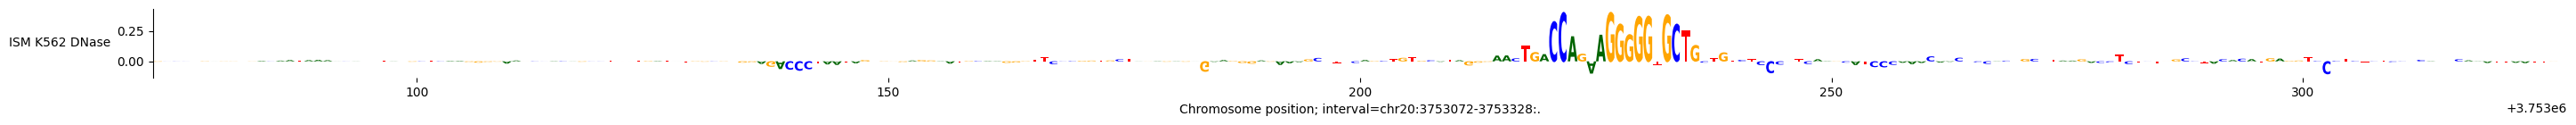

In [ ]:
plot_components.plot(
    [
        plot_components.SeqLogo(
            scores=ism_result,
            scores_interval=ism_interval,
            ylabel='ISM K562 DNase',
        )
    ],
    interval=ism_interval,
    fig_width=35,
)

plt.show()

This plot shows that the sequence between positions ~225 to ~240 has the
strongest effect on predicted nearby DNAse in K562 cells.

These contribution scores can be used to systematically discover motifs
important for different modalities and cell types, find the transcription
factors binding those motifs and map motif instances across the genome. Here are
a few tools you can use to do this: -
[tfmodisco-lite](https://github.com/jmschrei/tfmodisco-lite/) -
[tangermeme](https://github.com/jmschrei/tangermeme) -
[tomtom](https://meme-suite.org/meme/tools/tomtom)

## Making mouse predictions

So far, this notebook has focused on predictions for human
(`Organism.HOMO_SAPIENS`). To generate predictions for mouse, specify the
organism as `Organism.MUS_MUSCULUS` instead. Please note that the supported
ontology terms differ between species.

The following example demonstrates how to call `predict_sequence` for mouse
predictions:

In [ ]:
output = dna_model.predict_sequence(
    sequence='GATTACA'.center(
        dna_client.SEQUENCE_LENGTH_1MB, 'N'
    ),  # Pad to valid sequence length.
    organism=dna_client.Organism.MUS_MUSCULUS,
    requested_outputs=[dna_client.OutputType.DNASE],
    ontology_terms=['UBERON:0002048'],  # Lung.
)

And here is an example of calling `predict_interval` for a mouse genomic
interval:

In [ ]:
interval = genome.Interval('chr1', 3_000_000, 3_000_001).resize(
    dna_client.SEQUENCE_LENGTH_1MB
)

output = dna_model.predict_interval(
    interval=interval,
    organism=dna_client.Organism.MUS_MUSCULUS,
    requested_outputs=[dna_client.OutputType.RNA_SEQ],
    ontology_terms=['UBERON:0002048'],  # Lung.
)

output.rna_seq.values.shape

(1048576, 3)

## Conclusion

That's it for the quick start guide. To dive in further, check out our
[other tutorials](https://www.alphagenomedocs.com/tutorials/index.html).

In [ ]:
# @title Install AlphaGenome

# @markdown Run this cell to install AlphaGenome.
from IPython.display import clear_output
! pip install alphagenome
clear_output()

In [ ]:
# @title Setup and imports.

from io import StringIO
from alphagenome import colab_utils
from alphagenome.data import genome
from alphagenome.models import dna_client, variant_scorers
from google.colab import data_table, files
import pandas as pd
from tqdm import tqdm

data_table.enable_dataframe_formatter()

# Load the model.
dna_model = dna_client.create(colab_utils.get_api_key())

In [ ]:
# @title Score batch of variants with aggregation

# Load VCF file containing variants.
vcf_file = 'placeholder'  # @param

# We provide an example list of variants to illustrate.
vcf_file = """variant_id\tCHROM\tPOS\tREF\tALT
chr3_58394738_A_T_b38\tchr3\t58394738\tA\tT
chr8_28520_G_C_b38\tchr8\t28520\tG\tC
chr16_636337_G_A_b38\tchr16\t636337\tG\tA
chr16_1135446_G_T_b38\tchr16\t1135446\tG\tT
"""

vcf = pd.read_csv(StringIO(vcf_file), sep='\t')

required_columns = ['variant_id', 'CHROM', 'POS', 'REF', 'ALT']
for column in required_columns:
  if column not in vcf.columns:
    raise ValueError(f'VCF file is missing required column: {column}.')

organism = 'human'  # @param ["human", "mouse"] {type:"string"}

# @markdown Specify length of sequence around variants to predict:
sequence_length = '1MB'  # @param ["16KB", "100KB", "500KB", "1MB"] { type:"string" }
sequence_length = dna_client.SUPPORTED_SEQUENCE_LENGTHS[
    f'SEQUENCE_LENGTH_{sequence_length}'
]

# @markdown Specify which scorers to use to score your variants:
score_rna_seq = True  # @param { type: "boolean"}
score_cage = True  # @param { type: "boolean" }
score_procap = True  # @param { type: "boolean" }
score_atac = True  # @param { type: "boolean" }
score_dnase = True  # @param { type: "boolean" }
score_chip_histone = True  # @param { type: "boolean" }
score_chip_tf = True  # @param { type: "boolean" }
score_polyadenylation = True  # @param { type: "boolean" }
score_splice_sites = True  # @param { type: "boolean" }
score_splice_site_usage = True  # @param { type: "boolean" }
score_splice_junctions = True  # @param { type: "boolean" }

# @markdown Other settings:
download_predictions = True  # @param { type: "boolean" }

# Parse organism specification.
organism_map = {
    'human': dna_client.Organism.HOMO_SAPIENS,
    'mouse': dna_client.Organism.MUS_MUSCULUS,
}
organism = organism_map[organism]

# Parse scorer specification.
scorer_selections = {
    'rna_seq': score_rna_seq,
    'cage': score_cage,
    'procap': score_procap,
    'atac': score_atac,
    'dnase': score_dnase,
    'chip_histone': score_chip_histone,
    'chip_tf': score_chip_tf,
    'polyadenylation': score_polyadenylation,
    'splice_sites': score_splice_sites,
    'splice_site_usage': score_splice_site_usage,
    'splice_junctions': score_splice_junctions,
}

all_scorers = variant_scorers.RECOMMENDED_VARIANT_SCORERS
selected_scorers = [
    all_scorers[key]
    for key in all_scorers
    if scorer_selections.get(key.lower(), False)
]

# Remove any scorers or output types that are not supported for the chosen organism.
unsupported_scorers = [
    scorer
    for scorer in selected_scorers
    if (
        organism.value
        not in variant_scorers.SUPPORTED_ORGANISMS[scorer.base_variant_scorer]
    )
    | (
        (scorer.requested_output == dna_client.OutputType.PROCAP)
        & (organism == dna_client.Organism.MUS_MUSCULUS)
    )
]
if len(unsupported_scorers) > 0:
  print(
      f'Excluding {unsupported_scorers} scorers as they are not supported for'
      f' {organism}.'
  )
  for unsupported_scorer in unsupported_scorers:
    selected_scorers.remove(unsupported_scorer)


# Score variants in the VCF file.
results = []

for i, vcf_row in tqdm(vcf.iterrows(), total=len(vcf)):
  variant = genome.Variant(
      chromosome=str(vcf_row.CHROM),
      position=int(vcf_row.POS),
      reference_bases=vcf_row.REF,
      alternate_bases=vcf_row.ALT,
      name=vcf_row.variant_id,
  )
  interval = variant.reference_interval.resize(sequence_length)

  variant_scores = dna_model.score_variant(
      interval=interval,
      variant=variant,
      variant_scorers=selected_scorers,
      organism=organism,
  )
  results.append(variant_scores)

df_scores = variant_scorers.tidy_scores(results)

# Save original scores
if download_predictions:
  df_scores.to_csv('variant_scores.csv', index=False)
  files.download('variant_scores.csv')

# Aggregate scores by variant_id
# Calculate max, min, and mean for both raw_score and quantile_score
agg_max = df_scores.groupby('variant_id').agg({
    'raw_score': 'max',
    'quantile_score': 'max'
}).reset_index()
agg_max.columns = ['variant_id', 'raw_score_max', 'quantile_score_max']

agg_min = df_scores.groupby('variant_id').agg({
    'raw_score': 'min',
    'quantile_score': 'min'
}).reset_index()
agg_min.columns = ['variant_id', 'raw_score_min', 'quantile_score_min']

agg_mean = df_scores.groupby('variant_id').agg({
    'raw_score': 'mean',
    'quantile_score': 'mean'
}).reset_index()
agg_mean.columns = ['variant_id', 'raw_score_mean', 'quantile_score_mean']

# Save aggregated scores
if download_predictions:
  agg_max.to_csv('variant_scores_max.csv', index=False)
  files.download('variant_scores_max.csv')

  agg_min.to_csv('variant_scores_min.csv', index=False)
  files.download('variant_scores_min.csv')

  agg_mean.to_csv('variant_scores_mean.csv', index=False)
  files.download('variant_scores_mean.csv')

print("\nAggregated scores (max):")
display(agg_max)
print("\nAggregated scores (min):")
display(agg_min)
print("\nAggregated scores (mean):")
display(agg_mean)

df_scores

100%|██████████| 4/4 [00:05<00:00,  1.32s/it]


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,variant_id,scored_interval,gene_id,gene_name,gene_type,gene_strand,junction_Start,junction_End,output_type,variant_scorer,...,biosample_type,biosample_life_stage,data_source,endedness,genetically_modified,transcription_factor,histone_mark,gtex_tissue,raw_score,quantile_score
0,chr3:58394738:A>T,chr3:57870450-58919026:.,None,None,None,None,None,None,ATAC,"CenterMaskScorer(requested_output=ATAC, width=...",...,primary_cell,adult,encode,paired,False,NaN,NaN,NaN,-0.004951,-0.259272
1,chr3:58394738:A>T,chr3:57870450-58919026:.,None,None,None,None,None,None,ATAC,"CenterMaskScorer(requested_output=ATAC, width=...",...,in_vitro_differentiated_cells,adult,encode,paired,False,NaN,NaN,NaN,0.015554,0.343112
2,chr3:58394738:A>T,chr3:57870450-58919026:.,None,None,None,None,None,None,ATAC,"CenterMaskScorer(requested_output=ATAC, width=...",...,primary_cell,adult,encode,paired,False,NaN,NaN,NaN,-0.001731,-0.137554
3,chr3:58394738:A>T,chr3:57870450-58919026:.,None,None,None,None,None,None,ATAC,"CenterMaskScorer(requested_output=ATAC, width=...",...,primary_cell,adult,encode,paired,False,NaN,NaN,NaN,-0.009523,-0.449849
4,chr3:58394738:A>T,chr3:57870450-58919026:.,None,None,None,None,None,None,ATAC,"CenterMaskScorer(requested_output=ATAC, width=...",...,primary_cell,adult,encode,paired,False,NaN,NaN,NaN,-0.009647,-0.421820
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118281,chr16:1135446:G>T,chr16:611158-1659734:.,ENSG00000292423,ENSG00000292423,lncRNA,-,None,None,RNA_SEQ,GeneMaskLFCScorer(requested_output=RNA_SEQ),...,tissue,adult,gtex,paired,False,NaN,NaN,Skin_Not_Sun_Exposed_Suprapubic,-0.000437,-0.312224
118282,chr16:1135446:G>T,chr16:611158-1659734:.,ENSG00000292430,ENSG00000292430,lncRNA,+,None,None,RNA_SEQ,GeneMaskLFCScorer(requested_output=RNA_SEQ),...,tissue,adult,gtex,paired,False,NaN,NaN,Skin_Not_Sun_Exposed_Suprapubic,-0.001305,-0.641886
118283,chr16:1135446:G>T,chr16:611158-1659734:.,ENSG00000292431,ENSG00000292431,lncRNA,-,None,None,RNA_SEQ,GeneMaskLFCScorer(requested_output=RNA_SEQ),...,tissue,adult,gtex,paired,False,NaN,NaN,Skin_Not_Sun_Exposed_Suprapubic,0.000015,0.023068
118284,chr16:1135446:G>T,chr16:611158-1659734:.,ENSG00000292432,ENSG00000292432,lncRNA,-,None,None,RNA_SEQ,GeneMaskLFCScorer(requested_output=RNA_SEQ),...,tissue,adult,gtex,paired,False,NaN,NaN,Skin_Not_Sun_Exposed_Suprapubic,-0.000606,-0.402670
